In [6]:
import json
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
def json_to_expanded_df(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds
                
                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                # Append backend, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Column names based on the description (Backend, Z Readout, X3_2 ... Z0_0, count)
    columns = [
        'backend',
        'X3_2', 'X2_2', 'X1_2', 'X0_2', 'Z3_2', 'Z2_2', 'Z1_2', 'Z0_2',
        'X3_1', 'X2_1', 'X1_1', 'X0_1', 'Z3_1', 'Z2_1', 'Z1_1', 'Z0_1',
        'X3_0', 'X2_0', 'X1_0', 'X0_0', 'Z3_0', 'Z2_0', 'Z1_0', 'Z0_0',
        'z_readout', 'count'
    ]

    return pd.DataFrame(process_data(data), columns=columns)

In [15]:
#df_3X = json_to_expanded_df('data/qubit3X_results.json')
name = 'qubit1Z_d3'
json_to_expanded_df(f'{name}_results.json').to_csv(f'{name}.csv', index=False)

In [17]:
#df = json_to_expanded_df('data/qubit1Z_results.json')
df = pd.read_csv(f'{name}.csv')
df

,backend,X3_2,X2_2,X1_2,X0_2,Z3_2,Z2_2,Z1_2,Z0_2,X3_1,...,X3_0,X2_0,X1_0,X0_0,Z3_0,Z2_0,Z1_0,Z0_0,z_readout,count
0,ibm_sherbrooke,0,0,1,0,0,1,0,1,0,...,1,1,0,0,0,1,1,1,1,1
1,ibm_sherbrooke,0,1,0,1,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
2,ibm_sherbrooke,1,0,1,0,0,1,0,0,0,...,0,1,1,0,0,1,1,1,0,1
3,ibm_sherbrooke,1,1,0,1,1,1,1,1,0,...,1,0,0,0,1,1,0,1,1,1
4,ibm_sherbrooke,0,1,0,0,0,1,1,1,0,...,0,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,ibm_brisbane,1,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,1,1,1
14992,ibm_brisbane,1,1,1,0,0,1,1,0,1,...,0,0,0,1,0,1,0,0,1,1
14993,ibm_brisbane,1,1,0,1,1,0,0,1,0,...,1,0,0,0,1,1,0,0,0,1
14994,ibm_brisbane,1,1,0,1,1,0,0,1,0,...,0,1,0,0,1,1,0,1,0,1


### New Features:
- `readout_match`: Binary feature; 1 if the logical readout (L) matches the expected readout, otherwise 0.
- `index_flip`: Eight columns (index_flip_0 to index_flip_7), representing the number of bit flips for each index between the three rounds.
- `agreement`: Proportion of bits that agree across all three rounds for each row.
- `flip_errs`: Count of the number of errors (1s) in the last four bits (Z3, Z2, Z1, Z0) of each round, where these bits should always be zero.

In [20]:
classifier, df, y_test, y_pred = build_backend_classifier(df)

Accuracy: 57.97%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.57      0.55      0.56      1476
      ibm_kyiv       0.61      0.66      0.63      1499
ibm_sherbrooke       0.55      0.53      0.54      1524

      accuracy                           0.58      4499
     macro avg       0.58      0.58      0.58      4499
  weighted avg       0.58      0.58      0.58      4499



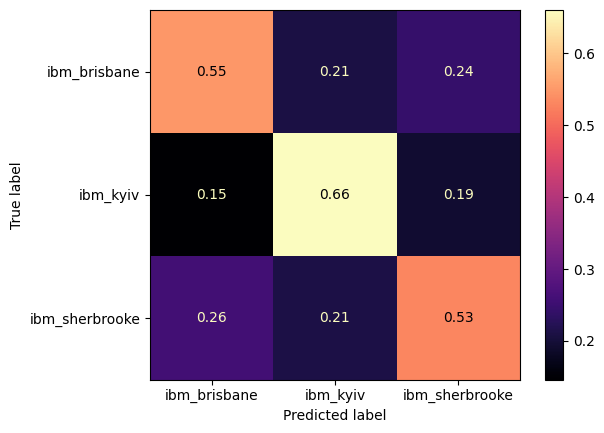

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

In [95]:
def json_to_expanded_df(json_file, d = 5, num_rounds = 3):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds

                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                
                # Append backend, expanded bits, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Dynamically generate column names based on the bitstring length
    measure_bits = (d*d)-1  # 24 bits per round of d=5

    columns = ['backend']
    for r in range(num_rounds):
        for q in range(measure_bits):
            columns.append(f'bit_{q}_round_{r}')

    columns += ['z_readout', 'count']
    return pd.DataFrame(process_data(data), columns=columns)

def calculate_index_flip(row, measure_bits):
    """Calculate the number of flips for each bit between rounds."""
    flips = []
    
    # Iterate through the measure_bits bits 
    for i in range(measure_bits):
        # Check flips between round_0, round_1, and round_2
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Count the flips between consecutive rounds
        flip_count = (bit_r0 != bit_r1) + (bit_r1 != bit_r2)
        flips.append(flip_count)
    
    return flips

def calculate_agreement(row, measure_bits):
    """Calculate the agreement between rounds for each bit."""
    agreement_count = 0

    # Iterate through the measure_bits bits and check if they agree across rounds
    for i in range(measure_bits):
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Check if the bits are the same in all rounds
        if bit_r0 == bit_r1 == bit_r2:
            agreement_count += 1

    return agreement_count / measure_bits  # Proportion of agreement

def calculate_flip_errs(row, measure_bits):
    """
    Calculate the number of errors (1s) in the last measure_bits/2 bits of each round.

    Parameters:
    row: The row containing the bits data.
    measure_bits: The total number of measurement bits. 
                  The function will check the last measure_bits/2 bits for errors.
    """
    flip_errs = 0
    half_measure_bits = measure_bits // 2  # Calculate half of measure_bits

    # Iterate through the last half_measure_bits bits for each round
    for i in range(measure_bits - half_measure_bits, measure_bits):
        flip_errs += row[f'bit_{i}_round_0']
        flip_errs += row[f'bit_{i}_round_1']
        flip_errs += row[f'bit_{i}_round_2']

    return flip_errs

def build_backend_classifier(df, expected_readout=0, d=5):
    measure_bits = (d*d)-1
    
    df = df[df['backend'] != 'aer_simulator'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_kyoto'].copy() 
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    
    # index_flip_cols (flips between rounds)
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

    # flip_errs (count of errors in the last measure_bits/2 bits of each round)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
    # Select features for training (excluding backend and count)
    X = df.drop(columns=['backend', 'count'])
    y = df['backend']  # Target
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output accuracy and classification report
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, df, y_test, y_pred

Accuracy: 58.50%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.57      0.56      0.57      1476
      ibm_kyiv       0.62      0.67      0.64      1499
ibm_sherbrooke       0.56      0.53      0.54      1524

      accuracy                           0.59      4499
     macro avg       0.58      0.59      0.58      4499
  weighted avg       0.58      0.59      0.58      4499



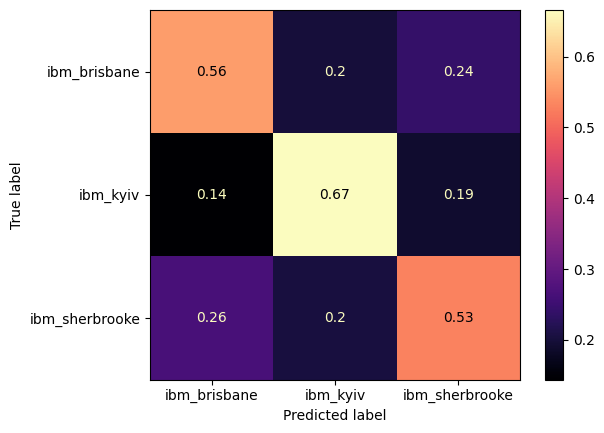

In [99]:
json_file = 'data/qubit1Z_d3_results.json'
df = json_to_expanded_df(json_file, d=3)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=3)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

Accuracy: 76.67%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.74      0.70      0.72      1492
      ibm_kyiv       0.79      0.84      0.82      1484
ibm_sherbrooke       0.76      0.76      0.76      1524

      accuracy                           0.77      4500
     macro avg       0.77      0.77      0.77      4500
  weighted avg       0.77      0.77      0.77      4500



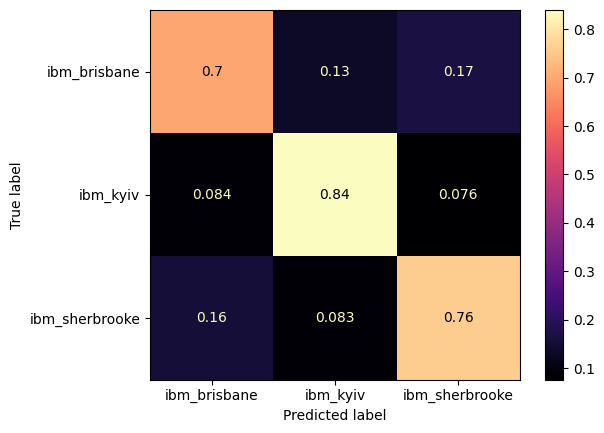

In [98]:
json_file = 'data/qubit1Z_d5_results.json'
df = json_to_expanded_df(json_file, d=5)
clf, updated_df, y_test, y_pred = build_backend_classifier(df, d=5)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

- increase # of mappings to classify
- classify based on "older" transpilations / qpys
- change to binary classification
- mappings would only matter for qPuf, train one classifier per mapping

- rerun saved transpilations from d=5 tomorrow, next week
- implement arbitrary mapping?
- generate confusion matrix across machines and mappings
- gernerate a new classifier per mapping => you expect to know which mapping you're working with
    - pull the classifier that you generated for that backend & mapping
    - ex: have brisbane mapping a, everything is labeled as brisbane_a or not

```python
for backend in backends:
    for mapping_label in ["a", "b", "c"]:
        random_layout = np.random.permutation(backend.num_qubits)[
            : qc.num_qubits
        ]
        qc_transpiled = transpile(qc, backend, initial_layout=random_layout)
```